# BertTopic

Understanding internals of BertTopic

In [1]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=04e772f918d67aefc93191835c6eb500be01b8d06da9e611056905ffc48850fa
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [2]:
import numpy as np
import pandas as pd
import os
import email
from tqdm import notebook

import torch

from sentence_transformers import SentenceTransformer

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/enron-email-dataset/emails.csv


In [3]:
device = 'cuda'
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [4]:
emails_df = pd.read_csv('/kaggle/input/enron-email-dataset/emails.csv', nrows=50000)
emails_df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [5]:
emails_df.shape

(50000, 2)

In [6]:
emails_df.iloc[10].message

'Message-ID: <33076797.1075855687515.JavaMail.evans@thyme>\nDate: Mon, 16 Oct 2000 06:42:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: buck.buckner@honeywell.com\nSubject: Re: FW: fixed forward or other Collar floor gas price terms\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: "Buckner, Buck" <buck.buckner@honeywell.com> @ ENRON\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Dec2000\\Notes Folders\\\'sent mail\nX-Origin: Allen-P\nX-FileName: pallen.nsf\n\nMr. Buckner,\n\n For delivered gas behind San Diego, Enron Energy Services is the appropriate \nEnron entity.  I have forwarded your request to Zarin Imam at EES.  Her phone \nnumber is 713-853-7107.  \n\nPhillip Allen'

In [7]:
def standard_format(df, Series, string, slicer):
    """Drops rows containing messages without some specified value in the expected locations. 
    Returns original dataframe without these values. Don't forget to reindex after doing this!!!"""
    rows = []
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        if string not in message_words[slicer]:
            rows.append(row)
    df = df.drop(df.index[rows])
    return df

In [8]:
x = len(emails_df.index)
emails_df = standard_format(emails_df, emails_df.message, 'Subject:', 4)
emails_df = emails_df.reset_index()
print("Got rid of {} useless emails! That's {}% of the total number of messages in this dataset.".format(x - len(emails_df.index), np.round(((x - len(emails_df.index)) / x) * 100, decimals=2)))

Got rid of 12485 useless emails! That's 24.97% of the total number of messages in this dataset.


In [9]:
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

In [10]:
def get_subjects(messages):
    subjects = []
    for msg in messages:
        subjects.append(msg['Subject'])
    return subjects

In [11]:
messages = list(map(email.message_from_string, emails_df['message']))
emails_df['content'] = list(map(get_text_from_email, messages))
emails_df['subject'] = get_subjects(messages)
emails_df.head()

,index,file,message,content,subject
0,0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,
1,1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,Re:
2,2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,Re: test
3,3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...",
4,4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,Re: Hello


In [12]:
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [13]:
text_df = emails_df[['subject', 'content']].dropna().copy()
text_df['text'] = text_df[["subject", "content"]].apply(" ".join, axis=1)
text_df.head()

,subject,content,text
0,,Here is our forecast\n\n,Here is our forecast\n\n
1,Re:,Traveling to have a business meeting takes the...,Re: Traveling to have a business meeting takes...
2,Re: test,test successful. way to go!!!,Re: test test successful. way to go!!!
3,,"Randy,\n\n Can you send me a schedule of the s...","Randy,\n\n Can you send me a schedule of the ..."
4,Re: Hello,Let's shoot for Tuesday at 11:45.,Re: Hello Let's shoot for Tuesday at 11:45.


In [14]:
BATCH_SIZE=32
N = len(text_df)

In [16]:
embeddings = model.encode(text_df['text'].values, device=device)

Batches:   0%|          | 0/1173 [00:00<?, ?it/s]

In [17]:
embeddings.shape

(37515, 384)

Dimensionality reduction using umap

In [18]:
!pip install umap-learn
!pip install hdbscan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 40.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp310-cp310-linux_x86_64.whl size=818347 sha256=0dee191f53db7ab9d0b479607f2

In [19]:
import umap
import plotly.express as px
import hdbscan

In [42]:
umap_model = umap.UMAP(n_components=3, n_neighbors=20)  # by default this is 2
u = umap_model.fit_transform(embeddings)

/opt/conda/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!



In [48]:
fig = px.scatter_3d(
    u, x=0, y=1, z=2
)
fig.update_traces(marker_size=8)
fig.show()

In [49]:
hdb = hdbscan.HDBSCAN()
hdb.fit(u)

HDBSCAN()

Aim is to get 5 clusters

<AxesSubplot: ylabel='$\\lambda$ value'>

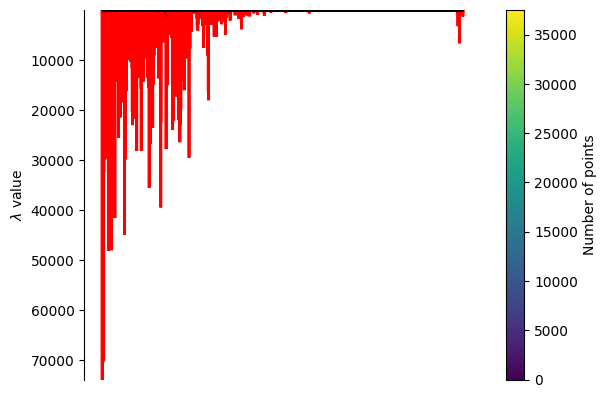

In [50]:
hdb.condensed_tree_.plot(select_clusters=True)

<AxesSubplot: ylabel='$\\lambda$ value'>

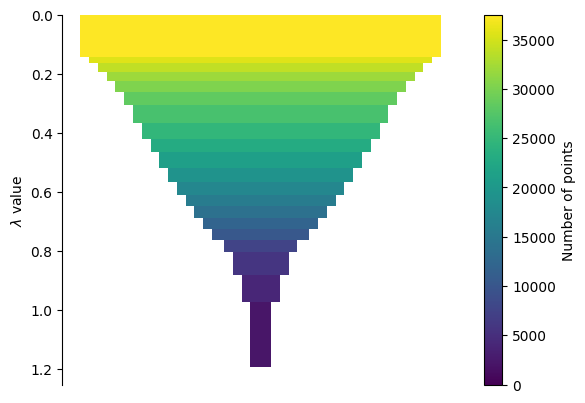

In [51]:
hdb = hdbscan.HDBSCAN(min_cluster_size=1000)
hdb.fit(u)

hdb.condensed_tree_.plot(select_clusters=True)

<AxesSubplot: ylabel='$\\lambda$ value'>

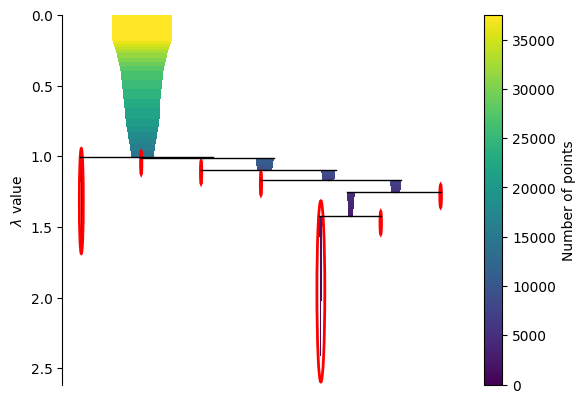

In [58]:
hdb = hdbscan.HDBSCAN(min_cluster_size=350,  prediction_data=True)
hdb.fit(u)

hdb.condensed_tree_.plot(select_clusters=True)

default min_samples gave better results and we had 3 clusters

In [59]:
labels = hdb.labels_
labels[:5]

array([-1, -1, -1, -1, -1])

In [60]:
# hdb = hdbscan.HDBSCAN(min_cluster_size=500)
# hdb.fit(u)

# labels = hdb.labels_
# labels[:5]

In [61]:
hdb.labels_.max()

6

In [62]:
fig = px.scatter(
    u, x=0, y=1, color=labels
)
fig.update_traces(marker_size=8)
fig.show()

In [63]:
import seaborn as sns

<AxesSubplot: ylabel='count'>

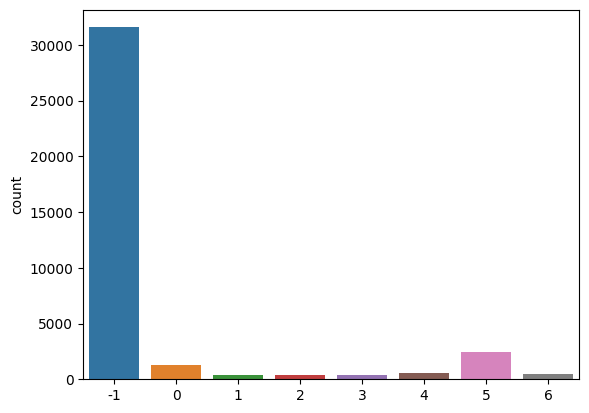

In [64]:
sns.countplot(x=labels)

most of the points are clustered as outliers. which is not good